Markov

- https://www.youtube.com/watch?v=sdp49vTanSk
- https://www.youtube.com/watch?v=SMZFHefftqw

**https://www.viralml.com/video-content.html?fm=yt&v=sdp49vTanSk**

https://finance.yahoo.com/quote/%5EGSPC/history?period1=1485734400&period2=1643500800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

- https://towardsdatascience.com/a-very-simple-method-of-weather-forecast-using-markov-model-lookup-table-f9238e110938

O ViralML se baseou nesse artigo:
- https://pkghosh.wordpress.com/2015/07/06/customer-conversion-prediction-with-markov-chain-classifier/

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re
import pandas as pd
import numpy as np
import datetime
from random import randint

# Dataset

In [2]:
gspc_df_master = pd.read_excel('markov_viralML.xlsx')
gspc_df_master['Date'] = pd.to_datetime(gspc_df_master['Date'], format='%b %d, %Y')
print(gspc_df_master.shape)

cut_off_date = '2010-01-01'

# gspc_df = gspc_df[gspc_df['Date']] >= cut_off_date

gspc_df = gspc_df_master[gspc_df_master['Date'].dt.year >= 2010]

print(gspc_df.shape)
gspc_df

(5802, 7)
(3040, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-28,4336.19,4432.72,4292.46,4431.85,4431.85,3936030000
1,2022-01-27,4380.58,4428.74,4309.50,4326.51,4326.51,4074330000
2,2022-01-26,4408.43,4453.23,4304.80,4349.93,4349.93,4046270000
3,2022-01-25,4366.64,4411.01,4287.11,4356.45,4356.45,3989420000
4,2022-01-24,4356.32,4417.35,4222.62,4410.13,4410.13,5172540000
...,...,...,...,...,...,...,...
3035,2010-01-08,1140.52,1145.39,1136.22,1144.98,1144.98,4389590000
3036,2010-01-07,1136.27,1142.46,1131.32,1141.69,1141.69,5270680000
3037,2010-01-06,1135.71,1139.19,1133.95,1137.14,1137.14,4972660000
3038,2010-01-05,1132.66,1136.63,1129.66,1136.52,1136.52,2491020000


In [3]:
gspc_df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [4]:
def normalize_to_number(df: pd.DataFrame):
    """
    Converte os campos que contém dados númericos no tipo Number (Int64 ou Float64)
    Returns:
        Dataframe
    Args:
        df (pd.DataFrame): Dataframe to normalize

    Returns:
        Pandas Dataframe
    """
    # log.debug(f"Antes Normalização: {df.dtypes}")
    # Substitui valor não informados '-' por Nan
    df = df.replace('-', pd.NA)
    
    #Obtem as colunas unicas (nomes)
    unique_columns = df.loc[:,~df.columns.duplicated()].columns
    
    #colunas com tipo nao definido
    cols_to_transform = df.select_dtypes(include=['object']).columns
    print(cols_to_transform)
    
    #conversao das colunas para tipo float
    df[cols_to_transform] = df[cols_to_transform].apply(pd.to_numeric, errors='ignore', downcast='float')
    
    # log.debug(f"Depois Normalização: {df.dtypes}")
    
    print(df.dtypes)
    return df

In [5]:
gspc_df = normalize_to_number(gspc_df)

Index([], dtype='object')
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object


In [6]:
gspc_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-28,4336.19,4432.72,4292.46,4431.85,4431.85,3936030000
1,2022-01-27,4380.58,4428.74,4309.50,4326.51,4326.51,4074330000
2,2022-01-26,4408.43,4453.23,4304.80,4349.93,4349.93,4046270000
3,2022-01-25,4366.64,4411.01,4287.11,4356.45,4356.45,3989420000
4,2022-01-24,4356.32,4417.35,4222.62,4410.13,4410.13,5172540000
...,...,...,...,...,...,...,...
3035,2010-01-08,1140.52,1145.39,1136.22,1144.98,1144.98,4389590000
3036,2010-01-07,1136.27,1142.46,1131.32,1141.69,1141.69,5270680000
3037,2010-01-06,1135.71,1139.19,1133.95,1137.14,1137.14,4972660000
3038,2010-01-05,1132.66,1136.63,1129.66,1136.52,1136.52,2491020000


# Random Set

In [7]:
def get_random_sets(size = 100000):
    # take random sets of sequential rows 
    new_set = []
    for row_set in range(0, size):

        row_quant     = randint(10, 30)
        row_start     = randint(0, len(gspc_df) - row_quant)
        market_subset = gspc_df.iloc[row_start:row_start + row_quant]
        Close_Date    = max(market_subset['Date'])

        if row_set%2000==0: 
            print(f'row_set: {str(row_set).rjust(8)} | row_quant: {str(row_quant).rjust(4)}| row_start: {str(row_start).rjust(8)} | market_subset: {str(market_subset.shape).rjust(8)} | Close_Date: {Close_Date}')

        # Close_Gap = (market_subset['Close'] - market_subset['Close'].shift(1)) / market_subset['Close'].shift(1)
        Close_Gap = market_subset['Close'].pct_change()
        High_Gap = market_subset['High'].pct_change()
        Low_Gap = market_subset['Low'].pct_change() 
        Volume_Gap = market_subset['Volume'].pct_change() 
        Daily_Change = (market_subset['Close'] - market_subset['Open']) / market_subset['Open']
        Outcome_Next_Day_Direction = (market_subset['Volume'].shift(-1) - market_subset['Volume'])

        new_set.append(pd.DataFrame({'Sequence_ID':[row_set]*len(market_subset),
                                'Close_Date':[Close_Date]*len(market_subset),
                               'Close_Gap':Close_Gap,
                               'High_Gap':High_Gap,
                               'Low_Gap':Low_Gap,
                               'Volume_Gap':Volume_Gap,
                               'Daily_Change':Daily_Change,
                               'Outcome_Next_Day_Direction':Outcome_Next_Day_Direction}))
        
    return new_set

In [8]:
%time my_set = get_random_sets(10000)

row_set:        0 | row_quant:   13| row_start:     2230 | market_subset:  (13, 7) | Close_Date: 2013-03-22 00:00:00
row_set:     2000 | row_quant:   20| row_start:      937 | market_subset:  (20, 7) | Close_Date: 2018-05-10 00:00:00
row_set:     4000 | row_quant:   19| row_start:     3009 | market_subset:  (19, 7) | Close_Date: 2010-02-17 00:00:00
row_set:     6000 | row_quant:   17| row_start:      240 | market_subset:  (17, 7) | Close_Date: 2021-02-17 00:00:00
row_set:     8000 | row_quant:   27| row_start:     2494 | market_subset:  (27, 7) | Close_Date: 2012-03-02 00:00:00
CPU times: total: 22.4 s
Wall time: 22.1 s


In [10]:
new_set_df = pd.concat(my_set)
print(new_set_df.shape)
new_set_df = new_set_df.dropna(how='any') 
print(new_set_df.shape)
new_set_df.tail()

(200446, 8)
(180446, 8)


,Sequence_ID,Close_Date,Close_Gap,High_Gap,Low_Gap,Volume_Gap,Daily_Change,Outcome_Next_Day_Direction
2763,9999,2011-02-22,-0.004167,-0.001525,-0.003176,0.005343,0.005488,2.368000e+07
2764,9999,2011-02-22,-0.006201,-0.008958,-0.007760,0.006068,0.002953,4.450400e+08
2765,9999,2011-02-22,-0.002876,-0.001831,-0.005255,0.113359,0.003324,-2.727300e+08
2766,9999,2011-02-22,-0.002349,-0.000757,0.006016,-0.062395,-0.001440,1.066240e+09
2767,9999,2011-02-22,0.002730,0.000956,-0.010348,0.260169,0.014312,-9.973400e+08


In [11]:
import pickle
# new_set_df.to_pickle('markov_viralML_step1.pkl.zip', compression='zip')
new_set_df.to_parquet('markov_viralML_step1_10K.parquet.zip', compression='gzip')

In [12]:
# new_set_df = pd.read_pickle('markov_viralML_step1.pkl.zip', compression='zip')
new_set_df = pd.read_parquet('markov_viralML_step1_10K.parquet.zip')

In [14]:
print(new_set_df.shape)
new_set_df.tail()

(180446, 8)


,Sequence_ID,Close_Date,Close_Gap,High_Gap,Low_Gap,Volume_Gap,Daily_Change,Outcome_Next_Day_Direction
2763,9999,2011-02-22,-0.004167,-0.001525,-0.003176,0.005343,0.005488,2.368000e+07
2764,9999,2011-02-22,-0.006201,-0.008958,-0.007760,0.006068,0.002953,4.450400e+08
2765,9999,2011-02-22,-0.002876,-0.001831,-0.005255,0.113359,0.003324,-2.727300e+08
2766,9999,2011-02-22,-0.002349,-0.000757,0.006016,-0.062395,-0.001440,1.066240e+09
2767,9999,2011-02-22,0.002730,0.000956,-0.010348,0.260169,0.014312,-9.973400e+08


In [38]:
# confirm sequence
# new_set_df[new_set_df['Close_Date'] == '1973-06-27'] {HLH, HLH, HHH, HHH, LLL, LML, LML, LLL, LHL, ...	

# Quantil

In [15]:
# create sequences
# simplify the data by binning values into three groups
 
# Close_Gap
new_set_df['Close_Gap_LMH'] = pd.qcut(new_set_df['Close_Gap'], 3, labels=["L", "M", "H"])

# High_Gap - not used in this example
new_set_df['High_Gap_LMH'] = pd.qcut(new_set_df['High_Gap'], 3, labels=["L", "M", "H"])

# Low_Gap - not used in this example
new_set_df['Low_Gap_LMH'] = pd.qcut(new_set_df['Low_Gap'], 3, labels=["L", "M", "H"])

# Volume_Gap
new_set_df['Volume_Gap_LMH'] = pd.qcut(new_set_df['Volume_Gap'], 3, labels=["L", "M", "H"])
 
# Daily_Change
new_set_df['Daily_Change_LMH'] = pd.qcut(new_set_df['Daily_Change'], 3, labels=["L", "M", "H"])

# new set
new_set_df = new_set_df[["Sequence_ID", 
                         "Close_Date", 
                         "Close_Gap_LMH", 
                         "Volume_Gap_LMH", 
                         "Daily_Change_LMH", 
                         "Outcome_Next_Day_Direction"]]

new_set_df['Event_Pattern'] = new_set_df['Close_Gap_LMH'].astype(str) + new_set_df['Volume_Gap_LMH'].astype(str) + new_set_df['Daily_Change_LMH'].astype(str)
 

In [20]:
print(new_set_df.shape)
new_set_df.head()

(180446, 7)


,Sequence_ID,Close_Date,Close_Gap_LMH,Volume_Gap_LMH,Daily_Change_LMH,Outcome_Next_Day_Direction,Event_Pattern
2231,0,2013-03-22,L,H,L,1.058200e+08,LHL
2232,0,2013-03-22,H,M,H,4.471200e+08,HMH
2233,0,2013-03-22,L,H,L,-6.316500e+08,LHL
2234,0,2013-03-22,H,L,L,2.011290e+09,HLL
2235,0,2013-03-22,H,H,L,-1.716590e+09,HHL


In [21]:
new_set_df['Outcome_Next_Day_Direction'].describe()

count    1.804460e+05
mean     3.013309e+05
std      7.268994e+08
min     -4.299510e+09
25%     -3.109300e+08
50%      7.460000e+06
75%      3.010000e+08
max      4.995080e+09
Name: Outcome_Next_Day_Direction, dtype: float64

# Compression

In [30]:
# reduce the set
compressed_set = new_set_df.groupby(['Sequence_ID', 
                                     'Close_Date'])['Event_Pattern'].apply(lambda x: "{%s}" % ', '.join(x)).reset_index()

print(compressed_set.shape)
compressed_set.head() 

(10000, 3)


,Sequence_ID,Close_Date,Event_Pattern
0,0,2013-03-22,"{LHL, HMH, LHL, HLL, HHL, MLH, LLM, MHL, HLH, ..."
1,1,2016-10-18,"{LLL, HHL, MHM, HLM, MHL, HLM, LHL, HMM, MHM, ..."
2,2,2014-04-15,"{LLH, LHL, HML, HLH, LHH, LML, HLL, HLM, MMM, ..."
3,3,2018-03-07,"{MMM, MHH, LMH, LHL, HLL, HLL, HLH, LLH, LHL}"
4,4,2011-10-20,"{LML, HMH, LLL, HMH, LHL, HHH, LLM, MMH, LHL, ..."


In [31]:
#compressed_outcomes = new_set_df[['Sequence_ID', 'Close_Date', 'Outcome_Next_Day_Direction']].groupby(['Sequence_ID', 'Close_Date']).agg()

compressed_outcomes = new_set_df.groupby(['Sequence_ID', 'Close_Date'])['Outcome_Next_Day_Direction'].mean()
compressed_outcomes = compressed_outcomes.to_frame().reset_index()
print(compressed_outcomes.shape)
compressed_outcomes.head()

(10000, 3)


,Sequence_ID,Close_Date,Outcome_Next_Day_Direction
0,0,2013-03-22,3.942000e+07
1,1,2016-10-18,1.039986e+08
2,2,2014-04-15,-1.255250e+07
3,3,2018-03-07,4.541222e+07
4,4,2011-10-20,1.750000e+07


In [32]:
compressed_outcomes.describe()

,Sequence_ID,Outcome_Next_Day_Direction
count,10000.00000,1.000000e+04
mean,4999.50000,2.034644e+05
std,2886.89568,6.933018e+07
min,0.00000,-5.879722e+08
25%,2499.75000,-2.661350e+07
50%,4999.50000,1.282281e+06
75%,7499.25000,2.904905e+07
max,9999.00000,6.553762e+08


In [33]:
compressed_set = pd.merge(compressed_set, compressed_outcomes, on= ['Sequence_ID', 'Close_Date'], how='inner')
print(compressed_set.shape)
compressed_set.head()

(10000, 4)


,Sequence_ID,Close_Date,Event_Pattern,Outcome_Next_Day_Direction
0,0,2013-03-22,"{LHL, HMH, LHL, HLL, HHL, MLH, LLM, MHL, HLH, ...",3.942000e+07
1,1,2016-10-18,"{LLL, HHL, MHM, HLM, MHL, HLM, LHL, HMM, MHM, ...",1.039986e+08
2,2,2014-04-15,"{LLH, LHL, HML, HLH, LHH, LML, HLL, HLM, MMM, ...",-1.255250e+07
3,3,2018-03-07,"{MMM, MHH, LMH, LHL, HLL, HLL, HLH, LLH, LHL}",4.541222e+07
4,4,2011-10-20,"{LML, HMH, LLL, HMH, LHL, HHH, LLM, MMH, LHL, ...",1.750000e+07


In [34]:
# # reduce set 

# compressed_set = new_set_df.groupby(['Sequence_ID', 'Close_Date','Outcome_Next_Day_Direction'])['Event_Pattern'].apply(lambda x: "{%s}" % ', '.join(x)).reset_index()

compressed_set['Event_Pattern'] = [''.join(e.split()).replace('{','')
                                   .replace('}','') for e in compressed_set['Event_Pattern'].values]
compressed_set.head()

,Sequence_ID,Close_Date,Event_Pattern,Outcome_Next_Day_Direction
0,0,2013-03-22,"LHL,HMH,LHL,HLL,HHL,MLH,LLM,MHL,HLH,MHH,LMM",3.942000e+07
1,1,2016-10-18,"LLL,HHL,MHM,HLM,MHL,HLM,LHL,HMM,MHM,LML,HLM,HH...",1.039986e+08
2,2,2014-04-15,"LLH,LHL,HML,HLH,LHH,LML,HLL,HLM,MMM,MHH,LMH,LL...",-1.255250e+07
3,3,2018-03-07,"MMM,MHH,LMH,LHL,HLL,HLL,HLH,LLH,LHL",4.541222e+07
4,4,2011-10-20,"LML,HMH,LLL,HMH,LHL,HHH,LLM,MMH,LHL,HLH,LLH,LH...",1.750000e+07


# Train / Test

In [35]:
# use last x days of data for validation
compressed_set_validation = compressed_set[compressed_set['Close_Date'] >= datetime.datetime.now() 
                                           - datetime.timedelta(days=90)] # Sys.Date()-90 

print(compressed_set_validation.shape)
compressed_set_validation.head()

(30, 4)


,Sequence_ID,Close_Date,Event_Pattern,Outcome_Next_Day_Direction
110,110,2022-01-24,"MLL,HLL,HML,HML,HMH,MML,HLM,MHH,LHH,MLL,HMM,MH...",-6.578286e+07
666,666,2022-01-25,"HHH,MLL,HLL,HML,HML,HMH,MML,HLM,MHH,LHH,MLL,HM...",-1.178069e+08
1008,1008,2022-01-27,"HML,MML,HHH,MLL,HLL,HML,HML,HMH,MML,HLM,MHH,LH...",-2.601960e+07
1043,1043,2022-01-21,"HLL,HML,HML,HMH,MML,HLM,MHH,LHH,MLL,HMM",2.604800e+07
1418,1418,2022-01-24,"MLL,HLL,HML,HML,HMH,MML,HLM,MHH,LHH,MLL,HMM,MH...",-9.004769e+07


In [36]:
compressed_set = compressed_set[compressed_set['Close_Date'] < datetime.datetime.now() 
                                           - datetime.timedelta(days=90)]  
compressed_set.shape

(9970, 4)

In [37]:
list(compressed_set)

['Sequence_ID', 'Close_Date', 'Event_Pattern', 'Outcome_Next_Day_Direction']

In [38]:
# drop date field
compressed_set = compressed_set[['Sequence_ID', 'Event_Pattern','Outcome_Next_Day_Direction']]
compressed_set_validation = compressed_set_validation[['Sequence_ID', 'Event_Pattern','Outcome_Next_Day_Direction']]

In [39]:
compressed_set.head()

,Sequence_ID,Event_Pattern,Outcome_Next_Day_Direction
0,0,"LHL,HMH,LHL,HLL,HHL,MLH,LLM,MHL,HLH,MHH,LMM",3.942000e+07
1,1,"LLL,HHL,MHM,HLM,MHL,HLM,LHL,HMM,MHM,LML,HLM,HH...",1.039986e+08
2,2,"LLH,LHL,HML,HLH,LHH,LML,HLL,HLM,MMM,MHH,LMH,LL...",-1.255250e+07
3,3,"MMM,MHH,LMH,LHL,HLL,HLL,HLH,LLH,LHL",4.541222e+07
4,4,"LML,HMH,LLL,HMH,LHL,HHH,LLM,MMH,LHL,HLH,LLH,LH...",1.750000e+07


# Keep big moves only and build outcome variable
Mantenha apenas grandes movimentos e construa a variavel de resultado

Apenas um filtro

In [51]:
compressed_set['Outcome_Next_Day_Direction'].describe()

count    9.969000e+03
mean     1.314089e+06
std      7.040371e+07
min     -5.875133e+08
25%     -2.668333e+07
50%      1.650870e+06
75%      2.951765e+07
max      5.168218e+08
Name: Outcome_Next_Day_Direction, dtype: float64

In [29]:
print(len(compressed_set['Outcome_Next_Day_Direction']))
len(compressed_set[abs(compressed_set['Outcome_Next_Day_Direction']) > 10000000])

9969


8031

In [52]:
# keep only big/interesting moves 
print('all moves:', compressed_set.shape[0])

compressed_set = compressed_set[abs(compressed_set['Outcome_Next_Day_Direction']) > 10000000]
print('step1:', compressed_set.shape[0])
compressed_set['Outcome_Next_Day_Direction'] = np.where((compressed_set['Outcome_Next_Day_Direction'] > 0), 1, 0)
print('step2:', compressed_set.shape[0])
compressed_set_validation['Outcome_Next_Day_Direction'] = np.where((compressed_set_validation['Outcome_Next_Day_Direction'] > 0), 1, 0)
print('big moves only:', len(compressed_set))

all moves: 9969
step1: 8031
step2: 8031
big moves only: 8031


In [53]:
compressed_set.head()

,Sequence_ID,Event_Pattern,Outcome_Next_Day_Direction
1,1,"LLM,MLM,MHH,LMH,LMM,MMM,MLH,LMM,MHM,HLH,LHL,HL...",0
2,2,"MLM,MHM,MMM,LLM,HHH,LLH,LLL,HHM",1
3,3,"LHH,LHL,HLH,LLH,LHL,HHH,LLH,LHL,HLL,HMM,MHH,LL...",1
4,4,"MHH,LLM,MMM,MML,HMH,LMM,MHM,LMM,HLL,HLL",0
5,5,"MHL,HML,HMH,LML,HMM,MMM,MMH,MMM,MHH,LMM,MMM,MM...",1


In [54]:
# create two data sets - won/not won
compressed_set_pos = compressed_set[compressed_set['Outcome_Next_Day_Direction']==1][['Sequence_ID', 'Event_Pattern']]
print(compressed_set_pos.shape)
compressed_set_neg = compressed_set[compressed_set['Outcome_Next_Day_Direction']==0][['Sequence_ID', 'Event_Pattern']]
print(compressed_set_neg.shape)

(4155, 2)
(3876, 2)


In [55]:
flat_list = [item.split(',') for item in compressed_set['Event_Pattern'].values ]
unique_patterns = ','.join(str(r) for v in flat_list for r in v)
unique_patterns = list(set(unique_patterns.split(',')))
len(unique_patterns)

27

In [56]:
unique_patterns

['HMH',
 'LHM',
 'MMM',
 'HLH',
 'MMH',
 'LHH',
 'HHM',
 'MLM',
 'MHM',
 'MLH',
 'LMH',
 'HLM',
 'LLM',
 'LHL',
 'LLH',
 'MLL',
 'MHH',
 'LLL',
 'HMM',
 'HLL',
 'LMM',
 'HML',
 'HHH',
 'MHL',
 'HHL',
 'MML',
 'LML']

In [57]:
compressed_set['Outcome_Next_Day_Direction'].head()  

1    0
2    1
3    1
4    0
5    1
Name: Outcome_Next_Day_Direction, dtype: int32

# Build the markov transition grid

In [58]:
# build the markov transition grid
def build_transition_grid(compressed_grid, unique_patterns):
    # build the markov transition grid

    patterns = []
    counts = []
    for from_event in unique_patterns:

        # how many times 
        for to_event in unique_patterns:
            pattern = from_event + ',' + to_event # MMM,MlM

            ids_matches = compressed_grid[compressed_grid['Event_Pattern'].str.contains(pattern)]
            found = 0
            if len(ids_matches) > 0:
                Event_Pattern = '---'.join(ids_matches['Event_Pattern'].values)
                found = Event_Pattern.count(pattern)
            patterns.append(pattern)
            counts.append(found)

    # create to/from grid
    grid_Df = pd.DataFrame({'pairs':patterns, 'counts': counts})

    grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
    grid_Df.head()

    grid_Df = grid_Df.pivot(index='x', columns='y', values='counts')

    grid_Df.columns= [col for col in grid_Df.columns]
#     del grid_Df.index.name

    # replace all NaN with zeros
    grid_Df.fillna(0, inplace=True)
    grid_Df.head()

    #grid_Df.rowSums(transition_dataframe) 
    grid_Df = grid_Df / grid_Df.sum(1)
    return (grid_Df)
 

In [59]:
grid_pos = build_transition_grid(compressed_set_pos, unique_patterns) 
grid_neg = build_transition_grid(compressed_set_neg, unique_patterns)

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_26916\2460623140.py:24: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_26916\2460623140.py:24: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str


In [61]:
print(grid_neg.shape)
grid_neg.head()

(27, 27)


,HHH,HHL,HHM,HLH,HLL,HLM,HMH,HML,HMM,LHH,...,LMM,MHH,MHL,MHM,MLH,MLL,MLM,MMH,MML,MMM
x,,,,,,,,,,,,,,,,,,,,,
HHH,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.092564,...,0.062090,0.000000,0.000432,0.006682,0.000000,0.020700,0.014741,0.010609,0.009766,0.006591
HHL,0.018349,0.034398,0.000000,0.120087,0.10925,0.077481,0.029461,0.036423,0.046875,0.000000,...,0.000000,0.000000,0.007347,0.011792,0.063361,0.019272,0.012351,0.000000,0.017578,0.004394
HHM,0.000000,0.012285,0.000000,0.000000,0.00650,0.000000,0.020332,0.005666,0.000000,0.025481,...,0.000875,0.033626,0.048401,0.016116,0.099862,0.179158,0.079681,0.025147,0.026367,0.055869
HLH,0.000000,0.013514,0.000000,0.000000,0.02050,0.000000,0.007884,0.000000,0.000000,0.091524,...,0.084390,0.002924,0.000000,0.010220,0.000000,0.032834,0.005976,0.014931,0.040527,0.014438
HLL,0.202318,0.165848,0.166132,0.164082,0.11550,0.097795,0.176349,0.174019,0.174769,0.000000,...,0.000000,0.034357,0.048833,0.056211,0.011708,0.032120,0.006375,0.022004,0.035645,0.015380


In [62]:
print(grid_pos.shape)
grid_pos.head()

(27, 27)


,HHH,HHL,HHM,HLH,HLL,HLM,HMH,HML,HMM,LHH,...,LMM,MHH,MHL,MHM,MLH,MLL,MLM,MMH,MML,MMM
x,,,,,,,,,,,,,,,,,,,,,
HHH,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073310,...,0.051320,0.000000,0.021000,0.004641,0.000000,0.036870,0.006888,0.004241,0.038001,0.005368
HHL,0.024474,0.043017,0.000000,0.109518,0.089191,0.090847,0.030145,0.048570,0.020952,0.000000,...,0.000000,0.000000,0.012180,0.005260,0.051617,0.045899,0.021954,0.000000,0.002603,0.007894
HHM,0.000000,0.018703,0.000000,0.000000,0.003612,0.000000,0.012058,0.017249,0.000000,0.014509,...,0.017479,0.059587,0.038639,0.015470,0.067786,0.145974,0.093844,0.040457,0.074440,0.047048
HLH,0.000000,0.009352,0.000000,0.000000,0.002779,0.000000,0.006029,0.000000,0.000000,0.090493,...,0.062105,0.020922,0.000000,0.010829,0.000000,0.002257,0.008610,0.019576,0.056221,0.043574
HLL,0.162524,0.174564,0.189063,0.134615,0.081967,0.077477,0.131833,0.133000,0.165714,0.000000,...,0.000000,0.010858,0.041579,0.039913,0.013682,0.052671,0.008179,0.024470,0.031234,0.027787


In [65]:
#FK - Isso é uma prova dos nove que mostra que o calculo esta errado. Mas tudo bem... segue o jogo.
grid_pos.T.sum().head()

x
HHH    1.034250
HHL    0.625468
HHM    0.756850
HLH    1.098298
HLL    1.526691
dtype: float64

In [82]:
def safe_log(x,y):
    try:
        lg = np.log(x/y)
    except:
        lg = 0
    return lg

# predict on out of sample data
actual = []
predicted = []
for seq_id in compressed_set_validation['Sequence_ID'].values:
    patterns = compressed_set_validation[compressed_set_validation['Sequence_ID'] == seq_id]['Event_Pattern'].values[0].split(',')
    pos = []
    neg = []
    log_odds = []
    
    for id in range(0, len(patterns)-1):
        # get log odds
        # logOdds = log(tp(i,j) / tn(i,j)
        if (patterns[id] in list(grid_pos) and patterns[id+1] in list(grid_pos) and patterns[id] in list(grid_neg) and patterns[id+1] in list(grid_neg)):
                
            numerator = grid_pos[patterns[id]][patterns[id+1]]
            denominator = grid_neg[patterns[id]][patterns[id+1]]
            if (numerator == 0 and denominator == 0):
                log_value =0
            elif (denominator == 0):
                log_value = np.log(numerator / 0.00001)
            elif (numerator == 0):
                log_value = np.log(0.00001 / denominator)
            else:
                log_value = np.log(numerator/denominator)
        else:
            log_value = 0
        
        log_odds.append(log_value)
        
        pos.append(numerator)
        neg.append(denominator)
      
    print('outcome:', compressed_set_validation[compressed_set_validation['Sequence_ID']==seq_id]['Outcome_Next_Day_Direction'].values[0])
    print(sum(pos)/sum(neg))
    print(sum(log_odds))

    actual.append(compressed_set_validation[compressed_set_validation['Sequence_ID']==seq_id]['Outcome_Next_Day_Direction'].values[0])
    predicted.append(sum(log_odds))

from sklearn.metrics import confusion_matrix

confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])

outcome: 0
1.1099907106163904
-1.1166008493989248
outcome: 1
0.9819011816201227
-3.8616700970798212
outcome: 0
0.9391661243918599
0.21778734386141455
outcome: 0
1.2157144617333373
-2.1659469750128943
outcome: 1
1.2845354209382986
-1.1153856692767443
outcome: 1
1.126547953059229
-2.550944221535606
outcome: 1
1.0987463851349522
-2.3314457125995447
outcome: 0
1.1578466491603654
2.4579783639271056
outcome: 1
1.0184361447162686
-2.1814144614282642
outcome: 1
1.0034997128187408
-2.193208606187624
outcome: 0
1.0419040139468072
2.011034775283635
outcome: 1
1.080788611374974
-0.9292499522175255
outcome: 1
0.9882770730173855
-4.068177821560465
outcome: 1
1.0180560732154484
-2.5116804609362795
outcome: 1
1.0106102154080967
-2.4914729200586705
outcome: 1
1.0053763324801193
-2.160001550034275
outcome: 1
0.9688409328377082
-0.8577235066956356
outcome: 0
1.1008108651956028
0.7085879205418704
outcome: 0
0.9498772347388297
-0.3551886571152016
outcome: 0
1.0373480325678957
0.22350975893607206
outcome: 0

-3.8940472695886457
outcome: 0
1.0419040139468072
2.011034775283635
outcome: 0
1.3436588818696262
0.9190302985374195
outcome: 1
0.6804054011742217
-1.562222967841145
outcome: 0
1.1390902577831812
-0.027215997821835147
outcome: 1
0.9331441996264696
-1.3631508437850874
outcome: 0
1.1147092480892236
-0.4484204301684258
outcome: 1
0.9553691726413004
-1.4174870472699066
outcome: 0
1.0021415289237543
-2.0238319345892717
outcome: 0
1.1226732606121295
3.611444201204429
outcome: 1
1.0103772158812712
-2.753848162463258
outcome: 1
1.0469730666643737
-2.755910829162354
outcome: 0
1.2843542018425025
1.434764530119089
outcome: 0
1.0131156029643105
-1.3131910328155003
outcome: 1
0.983400750279356
-2.595901598558649
outcome: 0
0.8553855798712352
-2.485420272954732
outcome: 0
0.9635452415615109
-3.0250752356058155
outcome: 1
0.9739067941504577
-4.172944060606293
outcome: 0
0.9091272687899002
-1.6250008858424505
outcome: 0
1.2850047745864897
-0.5757431721132059
outcome: 0
0.873222042287917
-3.5681979689

outcome: 1
1.2379891955668512
1.9787590032742928
outcome: 0
1.0955381927159376
-1.5729074559694805
outcome: 1
0.9702641977037929
-4.146951659925299
outcome: 1
1.0060510790486976
-2.746784870052249
outcome: 1
1.2318315033619185
-0.6193325509519385
outcome: 1
1.0263079577604322
-2.4235536172210574
outcome: 0
0.9397092096424634
-1.331877956807712
outcome: 0
1.0580699557339686
-0.8334176766911374
outcome: 0
1.044430605352324
-2.67882381724007
outcome: 1
1.1763721552891757
-3.1805000486476276
outcome: 1
1.0923641282813579
0.4386078130045172
outcome: 0
1.0887108202546567
3.4003887796040297
outcome: 0
1.0106102154080967
-2.4914729200586705
outcome: 0
0.9649236971273273
-4.825803400571583
outcome: 0
0.9173868856262788
-0.8413183662430602
outcome: 0
1.005903171009501
-1.7439802716790542
outcome: 1
1.2412063593412734
0.7892944456819753
outcome: 1
1.2379891955668512
1.9787590032742928
outcome: 1
1.2210257063361483
-0.5611956327107384
outcome: 0
0.9635452415615109
-3.0250752356058155
outcome: 1
1.

0.8553855798712352
-2.485420272954732
outcome: 0
0.8516350978500625
-2.7205246820707014
outcome: 1
1.235787171465384
1.7887629839128056
outcome: 0
0.9359891391410113
-1.6938359821628657
outcome: 1
0.9864158470131184
-2.570246758423504
outcome: 1
1.0265460257925714
-2.4774992275702985
outcome: 0
1.1024334288480726
2.034739299702635
outcome: 1
1.2052302219060949
-1.6933185148365926
outcome: 1
1.181824732862924
-0.35726294712615236
outcome: 0
1.1125268431802964
0.706995234674047
outcome: 0
0.9517432758956041
-3.6072042571645304
outcome: 0
0.9243162735929981
-0.05851671305308534
outcome: 0
0.9580061946376243
-0.12008424799923229
outcome: 0
1.0001519514676784
0.08570882691169601
outcome: 0
1.005850128030734
0.31713044607389346
outcome: 1
1.241397564561873
-0.5931563507396642
outcome: 1
1.2656988962140987
1.0767250488786022
outcome: 1
0.8636412006541424
-3.8153435529342916
outcome: 0
0.9897302528127281
0.49335073690475983
outcome: 0
1.1646112371730262
-0.010219653680106466
outcome: 1
1.06819

1.0705133907200866
1.8236838781022355
outcome: 1
0.9796294639560195
-3.94259904957286
outcome: 0
1.0010321645992701
1.7175265448444677
outcome: 0
1.0886513601965184
-3.9042363368727746
outcome: 1
1.0263079577604322
-2.4235536172210574
outcome: 0
1.3240239493996036
0.6341618455939285
outcome: 0
1.258456362318385
-2.0062569888836697
outcome: 0
1.0499225070800504
-2.1535735096837048
outcome: 0
1.1147280403631383
2.9004089269808375
outcome: 1
1.2379891955668512
1.9787590032742928
outcome: 0
0.8236663255724053
-3.1119660886446847
outcome: 1
1.0525615972175586
-1.9221518905215071
outcome: 0
1.1027486755831428
1.7317549053274615
outcome: 1
0.9734435546542701
-3.134088480944653
outcome: 1
1.0067190472638308
-1.9883397985574975
outcome: 1
0.9978964864051145
-2.38870764421719
outcome: 0
0.9434252040184024
-3.8940472695886457
outcome: 0
1.1899955224721361
0.5977794154047384
outcome: 0
1.0700466236742359
-0.7141127241055913
outcome: 0
1.0705133907200866
1.8236838781022355
outcome: 1
1.084418649430

outcome: 0
1.0886513601965184
-3.9042363368727746
outcome: 1
0.9713991773380458
-4.172606500060444
outcome: 0
1.2185259616270576
-1.843508358891647
outcome: 0
1.2721515478726633
-0.18735089718139925
outcome: 0
1.0846324389073292
-0.6801718506131845
outcome: 0
1.0705133907200866
1.8236838781022355
outcome: 0
1.378405092549794
2.1995387109426945
outcome: 0
1.1877643577303278
-0.6096840456056127
outcome: 0
1.5134470056566094
1.1228136620640923
outcome: 0
1.1125268431802964
0.706995234674047
outcome: 1
1.0566008396671926
-2.007050049464786
outcome: 0
0.9383900241582404
-5.118223077528354
outcome: 0
0.873222042287917
-3.568197968937273
outcome: 1
0.9064889300109723
-1.6666516463411236
outcome: 0
1.2843542018425025
1.434764530119089
outcome: 0
1.1165213478846414
-0.5712104709770387
outcome: 0
1.1305530879063614
-1.8820263053677475
outcome: 1
1.080788611374974
-0.9292499522175255
outcome: 0
1.283052887322952
-2.3976983954576525
outcome: 0
1.0686110766794346
1.676699818462148
outcome: 0
1.1182

outcome: 0
0.920519785688278
-1.6011635992896618
outcome: 0
1.1579795995367173
1.0057764030348544
outcome: 0
1.1444381098446288
-0.07572193263538307
outcome: 1
1.2656988962140987
1.0767250488786022
outcome: 1
1.258456362318385
-2.0062569888836697
outcome: 0
1.0190071551184172
-4.248369819550458
outcome: 0
1.0735893025814494
-3.9459938373891226
outcome: 0
0.983400750279356
-2.595901598558649
outcome: 1
0.9900316451492076
0.4352138186635597
outcome: 0
1.1744122574840423
2.641739617416328
outcome: 1
0.9331441996264696
-1.3631508437850874
outcome: 1
0.9882770730173855
-4.068177821560465
outcome: 1
1.1452807132684828
-1.0637626877245707
outcome: 0
1.474883411225262
1.9347443827422812
outcome: 0
1.1147280403631383
2.9004089269808375
outcome: 0
1.006247578304487
-3.1811817073403637
outcome: 0
1.135827392780841
-1.5472526158343356
outcome: 1
1.0525615972175586
-1.9221518905215071
outcome: 0
1.0700466236742359
-0.7141127241055913
outcome: 0
0.873222042287917
-3.568197968937273
outcome: 0
0.9155

outcome: 0
0.8553855798712352
-2.485420272954732
outcome: 0
1.3353430874525616
2.6005014390850416
outcome: 1
1.006085083423028
-1.9302028803162972
outcome: 0
1.2266151736607742
-0.021553135547199787
outcome: 1
1.2676210442150078
0.8893741516972029
outcome: 0
0.9972970996829921
-3.2480077425289804
outcome: 1
1.0492714291377354
-2.1334334388181837
outcome: 0
0.9309407919830632
-0.5650143093285603
outcome: 0
1.0106102154080967
-2.4914729200586705
outcome: 1
1.1336788444803532
-1.2686314953546973
outcome: 0
1.0324735560941418
-2.233490944813949
outcome: 1
0.953850505733682
0.15530357700332265
outcome: 1
0.9173868856262788
-0.8413183662430602
outcome: 1
1.1189950801859896
-0.35992892268036214
outcome: 0
1.1877643577303278
-0.6096840456056127
outcome: 0
0.9982161259207794
0.1447359205712383
outcome: 0
1.1027486755831428
1.7317549053274615
outcome: 1
1.0525615972175586
-1.9221518905215071
outcome: 1
0.953850505733682
0.15530357700332265
outcome: 0
0.8576421399188339
-1.9377230288807263
outcom

outcome: 0
1.0316255472664513
-0.7237362882251469
outcome: 0
0.9356580103092874
-0.8503093470713274
outcome: 1
0.9642584540193749
-1.062592314325762
outcome: 0
1.18349295665815
2.141759764793136
outcome: 1
0.966346500583973
-0.15324582607795287
outcome: 1
0.9064889300109723
-1.6666516463411236
outcome: 0
0.9580061946376243
-0.12008424799923229
outcome: 0
1.1243013695077873
-1.3686592579945782
outcome: 0
0.9511639623735882
-1.8506714240928055
outcome: 0
1.103381424970816
-1.5724426215212515
outcome: 1
1.2656988962140987
1.0767250488786022
outcome: 0
1.1720432364236315
1.9959491777551257
outcome: 1
0.9713991773380458
-4.172606500060444
outcome: 1
1.0106102154080967
-2.4914729200586705
outcome: 1
0.9882770730173855
-4.068177821560465
outcome: 0
1.0487184419593643
1.7963003832093014
outcome: 0
0.9243162735929981
-0.05851671305308534
outcome: 0
0.8842015124965856
-3.504407149953669
outcome: 1
1.176780330221134
1.8532322722580856
outcome: 0
1.0735893025814494
-3.9459938373891226
outcome: 0
1

array([[612, 428],
       [687, 118]], dtype=int64)

In [83]:
from sklearn.metrics import accuracy_score
score = accuracy_score(actual, [1 if p > 0 else 0 for p in predicted])
print('Accuracy:', round(score * 100,2), '%')

Accuracy: 39.57 %


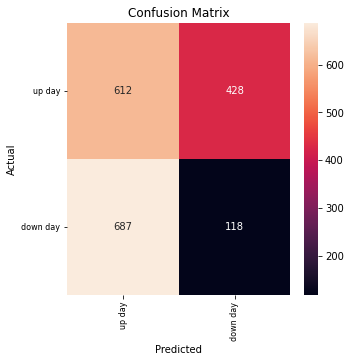

In [84]:
import seaborn as sns
cm = confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

ax.set_title('Confusion Matrix') 
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.xaxis.set_ticklabels(['up day','down day'])
ax.yaxis.set_ticklabels(['up day','down day'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)  
plt.show()